# <center> Proyecto integrador de la materia Comunicaciones Digitales

In [1]:
#---------------------------------------------------------------------------------
# Project    : Proyecto Integrador
# Authors    : Mugni Juan Mauricio
# Affiliation: UNC
# E-mail     : mauricio.mugni@mi.unc.edu.ar
#---------------------------------------------------------------------------------

## Consigna

Realizar una simulación de la transmisión y recepción con modulación LoRa, en el cual se pueda entender el funcionamiento. 

Luego agregarle ruido y los efectos del canal satelital.

## Resolución

Comenzamos importando las librerías necesarias.

In [7]:
import math
import cmath
import random
import numpy as np
import matplotlib.pyplot as plt
from sympy import li
from scipy.fft import fft, fftfreq, fftshift
from IPython.display import Image

### Marco Teórico

LoRa es la abreviatura de _Long Range_ (largo alcance), es un protocolo de comunicación que como su nombre indica permite llegar a distancias lejanas.

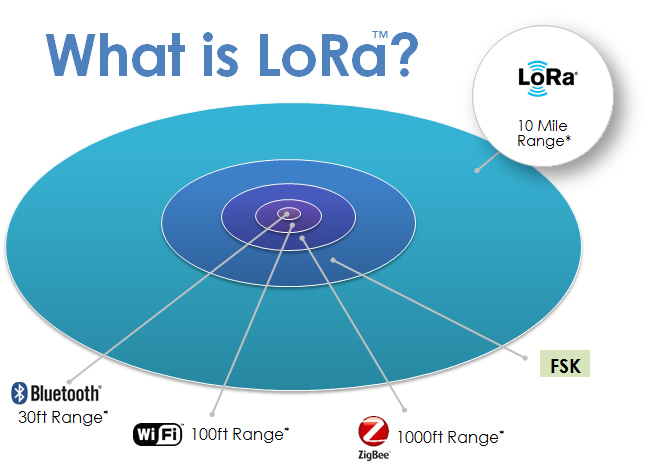

In [10]:
Image(filename='Imagenes/AlcanceLoRa.jpg')

Si ahora lo comparamos teniendo en cuenta el _ancho de banda_ y _alcance_, vemos que su ancho de banda es reducido comparado al resto. Por lo que no es utilizado para enviar vídeos o imagenes.

Pero se destaca por la distancia a la que puede llegar.

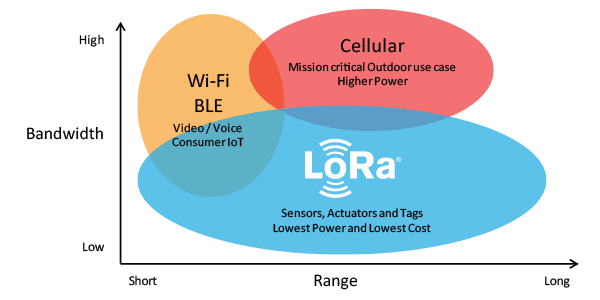

In [12]:
Image(filename='Imagenes/BW&Distancia.png')

No solo puede llegar lejos, además presenta un consumo muy reducido lo que lo convierte ideal para aplicaciones IoT (_Internet of Things_).  

Para alcanzar ese rango LoRa adopta la modulación *Chirp Spread Spectrum* (CSS) que se utiliza en aplicaciones espaciales y militares. Además utiliza la codificación de errores directa.

_Chirp Spread Spectrum_ (CSS) es una técnica de modulación que utiliza _chirps_ (señales cuya frecuencia aumenta o disminuye con el tiempo) para codificar información. Esta técnica es particularmente útil en entornos de comunicaciones inalámbricas debido a su resistencia al ruido, interferencias y su capacidad para penetrar obstáculos.

Un _chirp_ es una señal cuya frecuencia cambia linealmente con el tiempo. Existen dos tipos básicos de chirps: 
* chirps ascendentes (_up-chirps_), matemáticamente se puede escribir como:
    $$f(t)=f_0 + kt$$
* chirps descendentes (_down-chirps_):
    $$f(t)=f_0 - kt$$
  
donde $f_0$ es la frecuencia inicial y $k$ es la tasa de cambio de frecuencia.

La señal recibida realiza un barrido en frecuencia, desde una frecuencia incial a una límite. Es decir, cuando se alcanza la frecuencia máxima (mínima para el _down chirp_) se vuelve a la frecuencia mínima (máxima para el _down chirp_) y el proceso comienza nuevamente. 

En la imagen siguiente podemos ver como varía la frecuencia de la señal que se recibe. Puede ser ascendente (se mueve de izquierda a derecha la señal `verde` ) o descendente ( se mueve de derecha a izquierda la señal `verde`). Y lo que se visualiza en `azúl` es como la frecuencia se incrementa hasta llegar al valor máximo o al valor mínimo si disminuye la frecuencia, para los distintos bits a transmitir.

En verde vemos un mayor ancho de banda ya que es donde estamos buscando la señal con modulación LoRa.

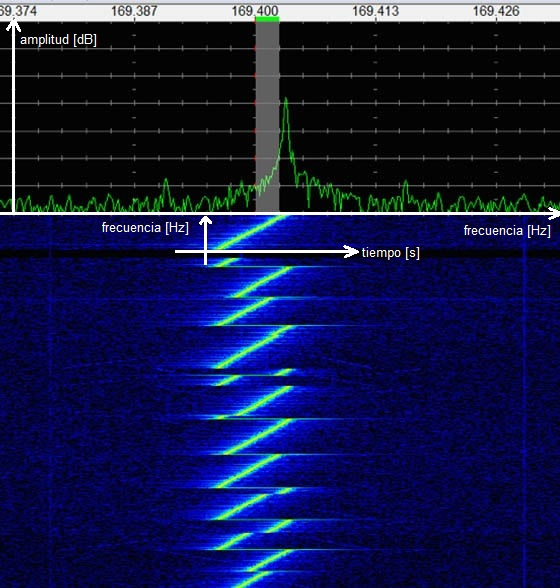

In [17]:
Image(filename='Imagenes/LoRa-Modulation.jpeg')

Podemos visualizar también el _chirp_ en el tiempo, para los dos casos mencionados.

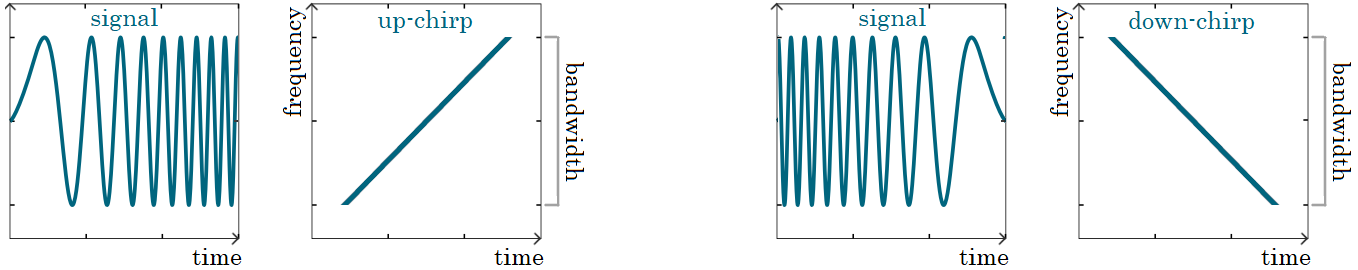

In [20]:
Image(filename='Imagenes/lora-chirps.png')

A esta señal de barrido también se la conoce como "chirrido", y puede cambiar su frecuencia a una velocidad constante (como se muestra anteriormente) o exponencial.

Los llamados pulsos de "chirrido" se envían como símbolos, que aumentan o disminuyen la frecuencia a lo largo del tiempo.

La transmisión de datos se realiza mediante la secuencia de estos pulsos de "chirrido".

En la siguiente imagen podemos ver como es la secuencia de "chirridos" enviados:

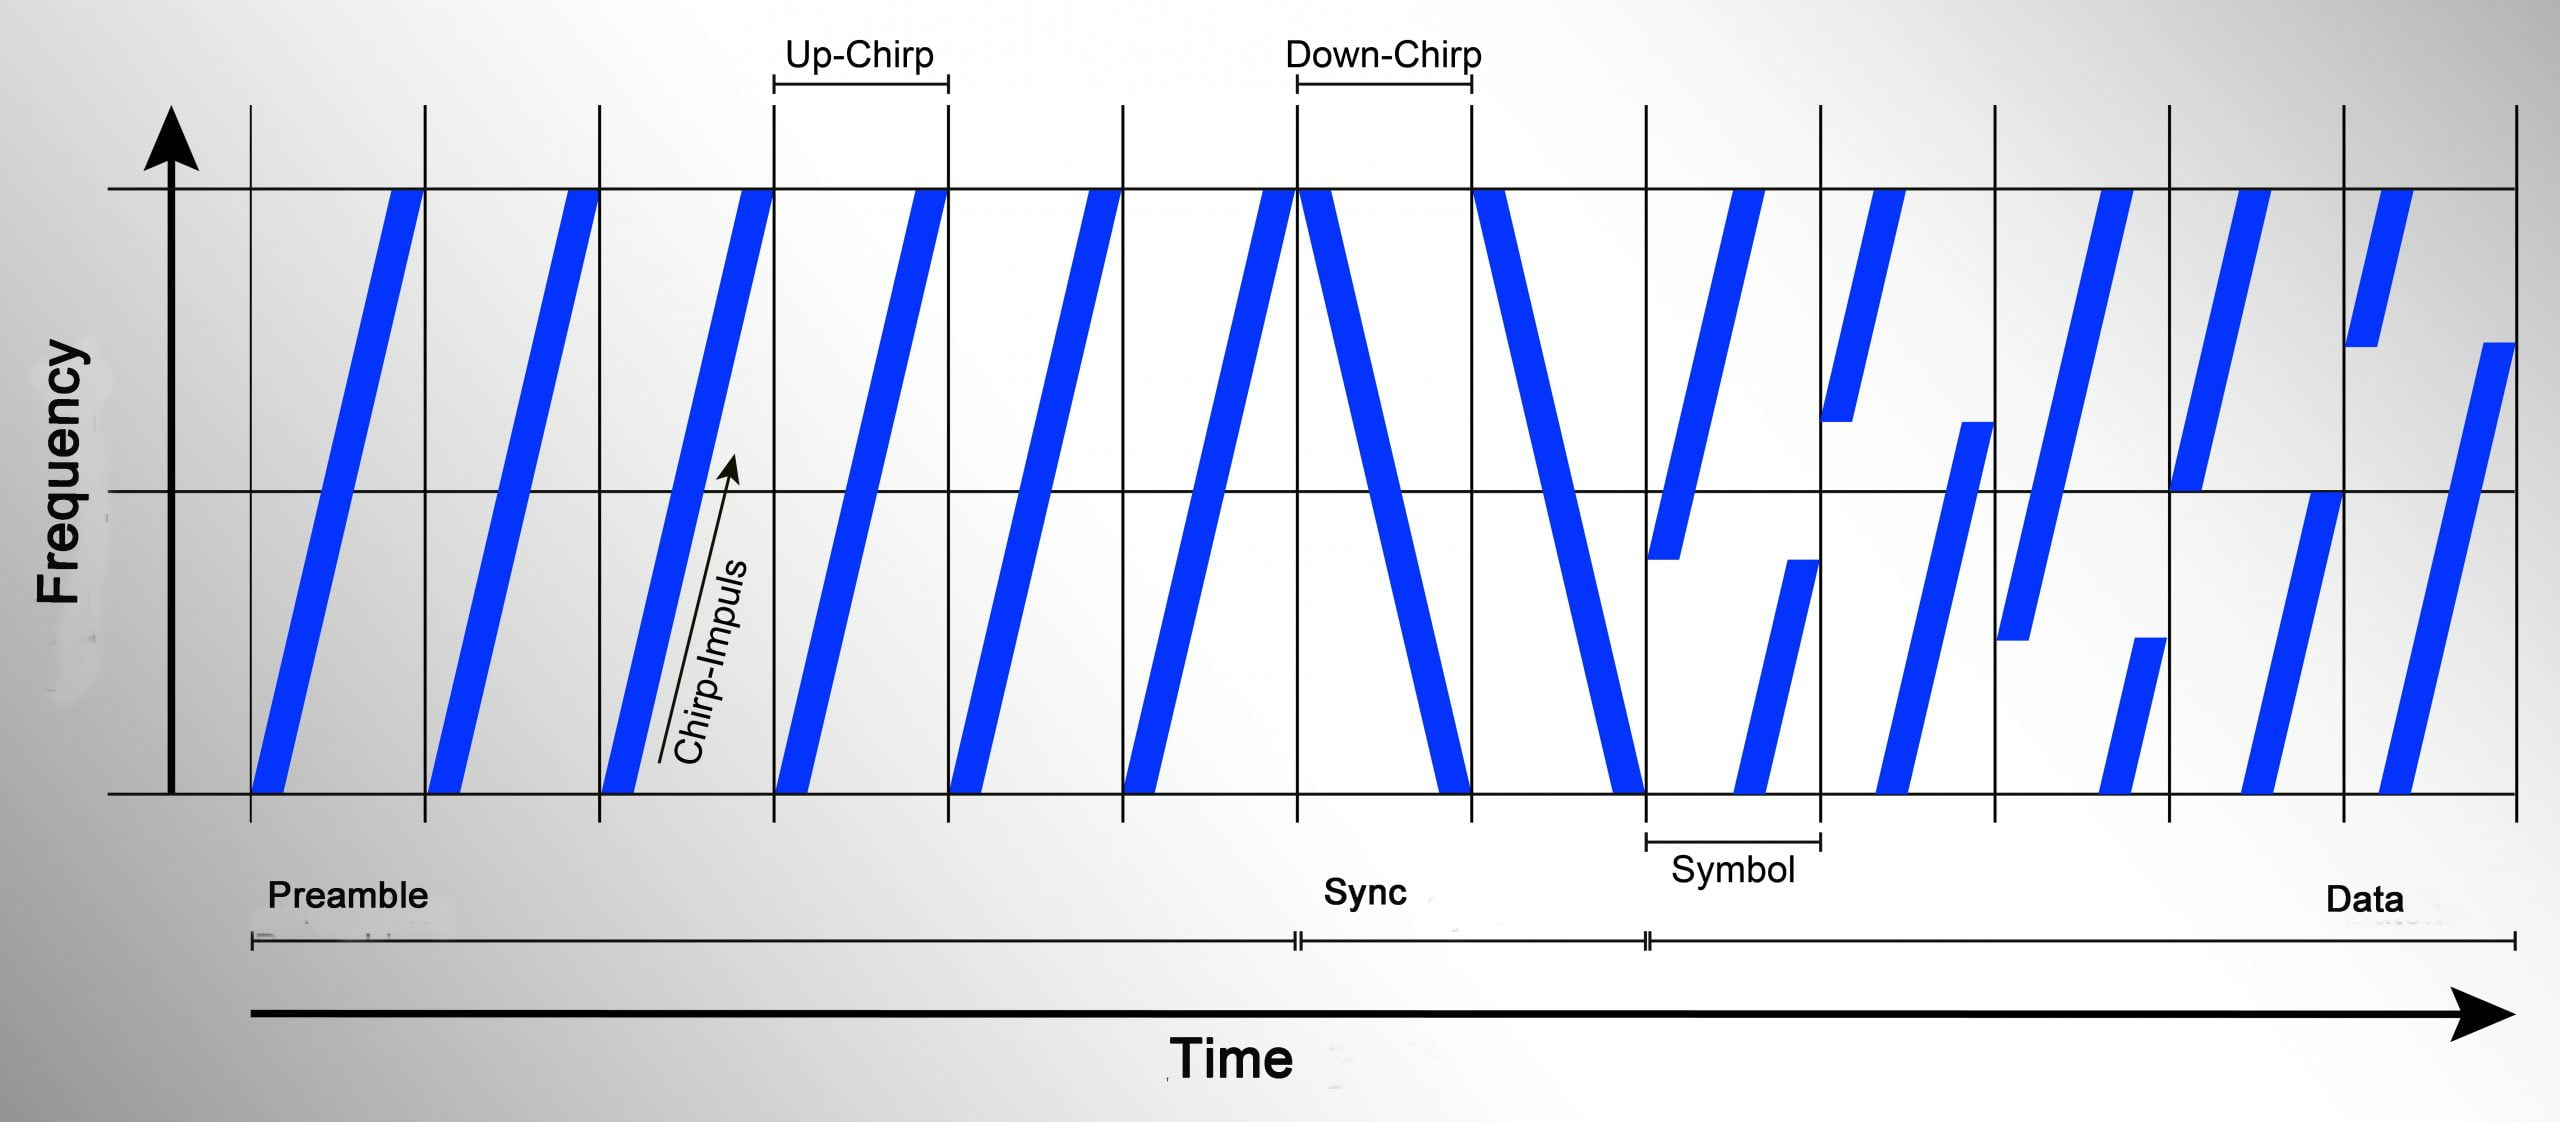

In [23]:
Image(filename='Imagenes/lora-Frequency-scaled.jpg')

Cuando se procesa un mensaje LoRa se transmite primero el `preámbulo`, que son varios "chirridos" constante para lograr la detección de la señal LoRa. Hay que tener en cuenta que el receptor puede estar desalineado por esta razón se envían varias veces el cero para poder calibrar al receptor. El preámbulo se compone de dos a diez _up-chirp_, es el símbolo cero repetido algunas veces. 

Los dos _down-chirp_ siguientes (dos chirridos descendentes) son para la `sincronización` de tiempo. Luego, se comienza con la transmisión de datos, en primer lugar el `símbolo`y luego los `datos`.

Para la demodulación, ocurre lo contrario. Primero se elimina el `preámbulo` y luego se averigua que símbolo se transmitió.

La idea de la decodificación LoRa es la siguiente: 

'Mientras codificamos LoRa, cambiamos cíclicamente la frecuencia de la señal LoRa. Entonces, si multiplicamos el "chirrido" detectado por el "chirrido" inverso obtendremos la señal con una frecuencia específica constante. Si tomamos la Transformada Rápida de Fourier (FFT - _Fast Fourier Transform_) sobre el símbolo, la parte de mayor energía representará el símbolo transmitido.'

A continuación se brinda un ejemplo para mayor aclaración:

> Supongamos que estamos transmitiendo un mensaje LoRa que tiene cuatro símbolos de preámbulo, dos símbolos de sincronización ($32$ , $32$) y cuatro símbolos de mensaje ($10$, $80$, $185$, $55$). Tomando un factor de dispersión de $8$. El mensaje se vería así:


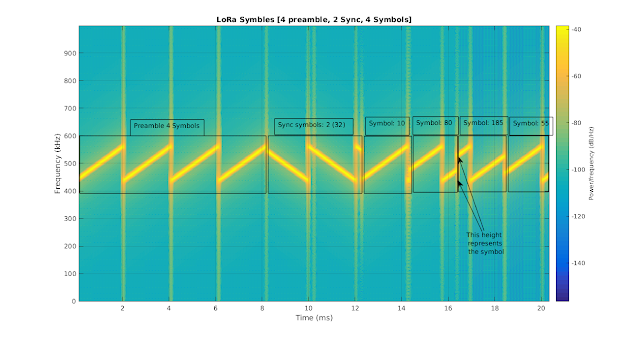

In [26]:
Image(filename='Imagenes/LoRa_Sym_generated.png')

> Como el _Spreading Factor_ es $8$, podemos transmitir $8$ bits por símbolo. Donde los símbolos van de $0$ a $255$.
> 
> Entonces el chirrido completo se divide por $256$, esto por que estamos usando $SP = 8$.
>
> En el lado del receptor, este mensaje se multiplica por un chirrido inverso (_down-chirps_). Y en el espectrograma se ve de la siguiente manera:

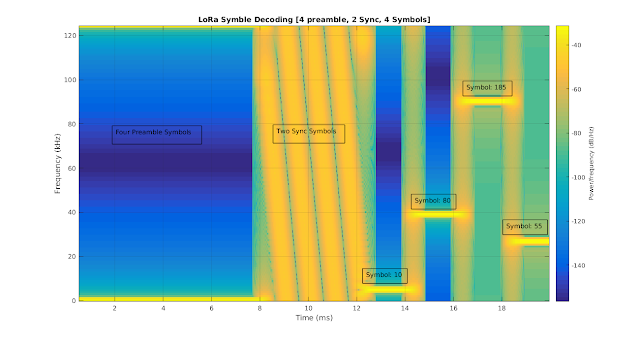

In [29]:
Image(filename='Imagenes/LoRa_Sym_decoding.png')

> Después de multiplicar por el _chirp_ inverso se observa el preámbulo, los símbolos de sincronización y los símbolos del mensaje.
> 
> Los símbolos del mensaje recibido tienen frecuencias constantes. En el eje $y$ se representa el símbolo y en el eje $x$ se representa el tiempo en el aire.
>
> Ahora se realiza la Transformada Rápida de Fourier para chequear cuales frecuencias tienen mayores energía.
>
> Y se obtiene lo siguiente:

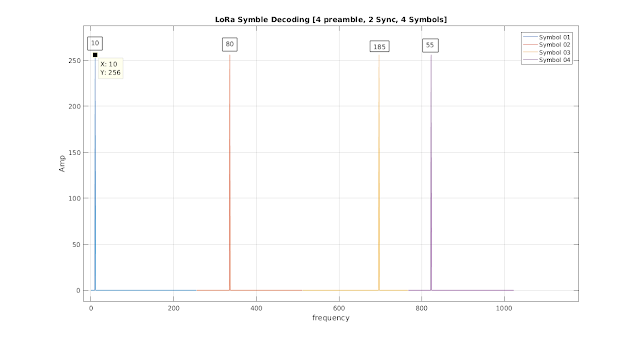

In [32]:
Image(filename='Imagenes/LoRa_Sym_FFT.png')

> Y estos son los símbolos obtenidos, las frecuencias que tienen más energía son un símbolo, y de esta manera se pueden extraer los datos.

La modulación LoRa es definida por los siguientes parametros:
* Ancho de banda (BW - _Bandwith_), es la diferencia entre la frecuencia mínima y máxima.
* Factor de dispersión (SF - _Spreading Factor_), es la cantidad de bits codificados por símbolo.
* (CR - _Coding Rate_), es una medidad de la cantidad de corrección de errores.

Un mayor _Spreading Factor_ me permite mayor alcance a coste de menor ancho de banda, es decir, menor transmisión de bits. 
En la siguiente imagen se muestra como aumenta el tiempo de transmisión al aumentar el factor de dispersión.

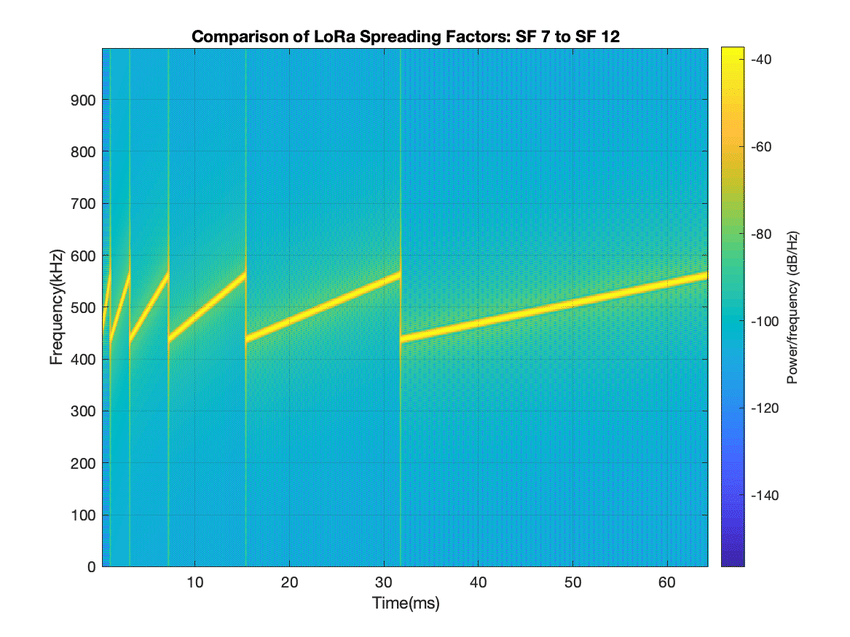

In [36]:
Image(filename='Imagenes/LoRa-uses-a-chirp-spread-spectrum-modulation-technique.png')

La duración de un símbolo se calcula como:
$$ \frac{2^{SF}}{BW}$$
Para elegir cierto _Spreading Factor_ se debe tener en cuenta no solo el alcance y la cantidad de datos a transmitir, también el oscilador del microcontrolador a utilizar. Para poder lograr el factor de disperción deseado, el ciclo de trabajo del microcontrolador debe tener una precisión del $1$ al $10$ por ciento.


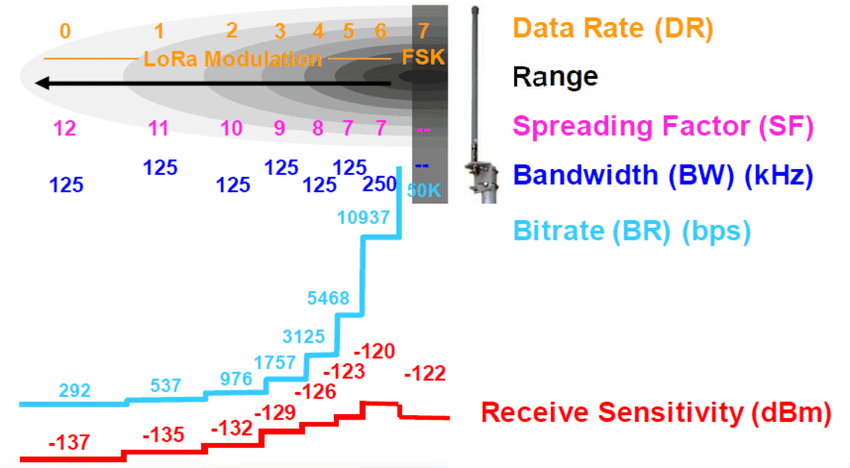

In [40]:
Image(filename='Imagenes/LoRa-Modulation-Parameters.png')

Las características claves de la tecnología LoRa son:
- Gran alcance: permite conectar más de 30 mil aparatos en areas rurales y penetrar densos espacios urbanos.
- Bajo consumo: requiere mínima energía, prolongando la vida útil de las baterías hasta 10 años.
- Seguridad: se caracteriza por la encriptación _end-to-end_ AES128, autenticación mutua y protección integrada
- Estandarización: disponibilidad global en cualquier parte del mundo.
- Geolocalización: permite el desarrollo de aplicaciones de rastreo GPS.
- Portatil: mantiene comunicaciones con dispositivos en movimiento sin sobrecargar el consumo.

Actualmente tiene aplicaciones en:
1. En la agricultura para el monitoreo del ganado. Se registran variables como la temperatura, su ubicación, y productividad del msimo.
2. En los edificios para predecir fallas, registrar variables como movimiento y temperatura; y el control de motores, luces, y otros dispositivos.
3. En las ciudades para hacer más eficiente el uso de la electricidad controlando la iluminación. Se ilumina de manera inteligente ciertas áreas.
4. En la idustria para monitorear recursos como gas, agua, tensión electrica, etc. Y poder controlar diversos procesos.

### Simulación de una transmisión y recepción con modulación LoRa de un solo símbolo

Se comienza simulando el caso para un solo símbolo modulado mediante LoRa.

In [239]:
SF  = 7                  # Spreading Factor [7,8,9,10,11,12]
BW  = 1000               # Ancho de banda
s   = 17                 # Símbolo a representar
SNR = 0                  # Signal Noise Radio
Fs  = 1000               # Frecuencia de muestreo 
ruido = 1                # Tipo de ruido: 0-> Sin ruido, 1 -> AWGN, 2 -> Canal Satelital

#### Transmisor

##### Modulación

A continuación se define la función para modular una onda para cada símbolo *s* dado, que más adelante se usara.

Los parámetros de entrada serán: 

$T_s = \frac{2^{SF}}{BW}$ y esto me indica la duración de cada símbolo, su periodo.

$num samples = T_s F_s$ es el número de muestras en un periodo. 

$s$ es el símbolo que se quiere representar.

$SF$ es el _Spreading Factor_ ya definido al comienzo.

Y esta función me retorna la modulación en frecuencia y en el tiempo de cada símbolo.

In [244]:
def generar_symb(Ts, num_samples, s, SF):
    
    k = s
    
    symb_f = np.zeros(num_samples, dtype=np.float64)
    symb_t = np.zeros(num_samples, dtype=np.complex128)

    for n in range(num_samples):
        
        if k >= 2**SF:
            k = k - 2**SF
        
        k = k + 1 
        symb_f[n] = k
        symb_t[n] = (1 / np.sqrt(2**SF)) * np.exp(1j * 2 * np.pi * k * (k / (2 * 2**SF)))  # Chirps ascendentes

    return symb_t, symb_f

Se procede a definir el periodo de cada símbolo y su tasa de muestreo, para hacer uso de la función anterior.

In [247]:
Ts = (2**SF)/BW            # Periodo de cada símbolo
num_samples = int(Ts * Fs) # Número de muestras

print("Duración de casa símbolo: ", Ts, " [S]")

Duración de casa símbolo:  0.128  [S]


Se modula una onda para el símbolo dado.

In [250]:
[symb_t, symb_f] = generar_symb(Ts, num_samples, s, SF)

Se define el vector tiempo del símbolo, y la cantidad de puntos que este tiene.

In [253]:
time_axis = np.arange(num_samples) * 1000 / Fs     #Vector tiempo que será usado en las imagenes siguiente
message_part = 2**SF                               # Cantidad de puntos de cada símbolo

Procedemos a gráficar como se vería las variaciones de frecuencia y tiempo por símbolo en el eje real.

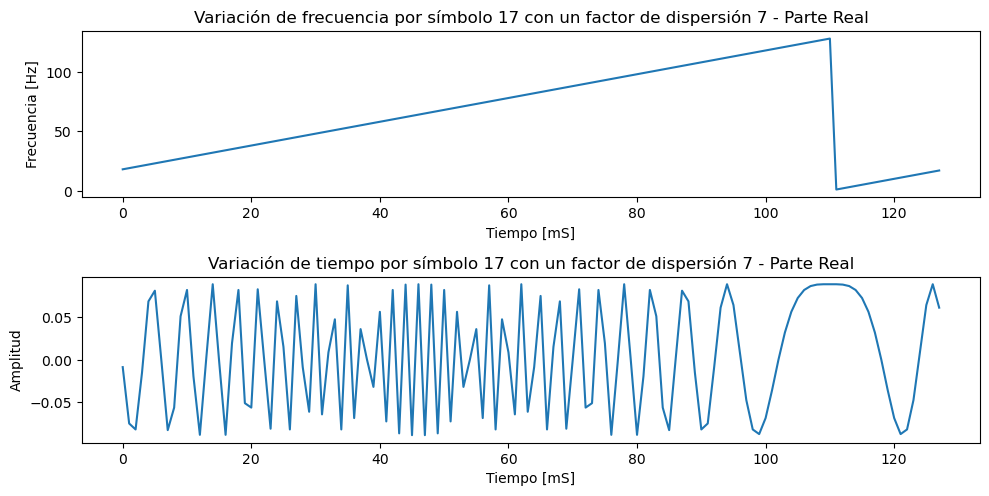

In [256]:
plt.figure(figsize=(10, 12))

# Subplot 1: Variación de frecuencia por símbolo
plt.subplot(5, 1, 1)
plt.plot( time_axis, symb_f.real)

title_Text1 = f"Variación de frecuencia por símbolo {str(s)} con un factor de dispersión {str(SF)} - Parte Real"
plt.title(title_Text1)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Frecuencia [Hz]")

# Subplot 2: Variación de tiempo por símbolo
plt.subplot(5, 1, 2)
plt.plot( time_axis, symb_t.real)

title_Text1 = f"Variación de tiempo por símbolo {str(s)} con un factor de dispersión {str(SF)} - Parte Real"
plt.title(title_Text1)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

Como estamos simulando un caso _up-chirp_, podemos ver que se inicia en la frecuencia del símbolo a transmitir y asciende hasta su máximo $2^{SF}$ provocando una discontinuidad, y vuelve a empezar.

En segunda gráfica notamos como cambia la frecuencia de la onda con la modulación. Se puede ver que en la discontinuidad (comienzo de la menor frecuencia y fin de la más alta) es donde la señal tiene menor frecuencia. 

#### Ruido

En este paso se le agrega ruido a la señal. Para ello se crea la siguiente función, donde los parámetros para pasarle son:
* `simbolo_lora` que representa el símbolo al cual hay que agregarle ruido.
* `SNR` como se explico antes se utiliza para comparar el nivel de ruido con respecto a la señal.
* `modo` que se utiliza para indicar el tipo de ruido que se vaya a agregar. 

In [261]:
def agregar_ruido(simbolo_lora, SNR, modo):

    if modo == 0: # Sin ruido - canal ideal
        
        return simbolo_lora
    
    else: # Ruido AWGN   
        # Cálculo de potencia de señal y conversión a decibelios
        prom_watts = np.mean(np.abs(simbolo_lora)**2)
        prom_db = 10 * np.log10(prom_watts)

        # Cálculo de ruido en watts
        prom_ruido_db = prom_db - SNR
        noise_avg_watts = 10 ** (prom_ruido_db / 10)

        # Generar ruido blanco complejo
        noise = np.sqrt(noise_avg_watts / 2) * (np.random.normal(0, 1, len(simbolo_lora)) + 1j * np.random.normal(0, 1, len(simbolo_lora)))

        # Añadir ruido a la señal original
        simb_ruidoso = simbolo_lora + noise
    
        return simb_ruidoso

Y ahora se agrega ruido a la señal. Se generan los símbolos ruidosos.

In [264]:
 symb_ruidoso = agregar_ruido(symb_t, SNR, ruido)

Y podemos nuevamente gráficar el símbolo en el tiempo para apreciar el efecto.

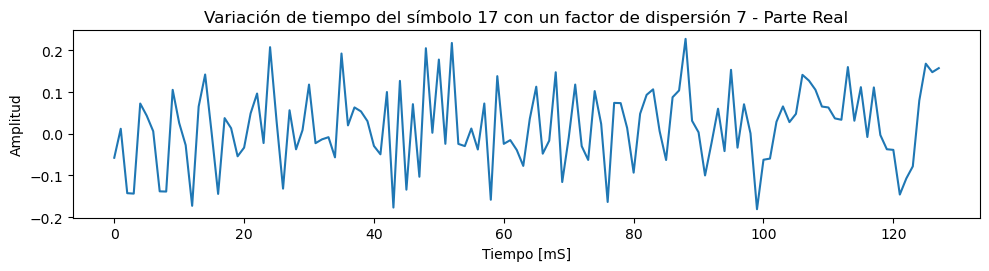

In [267]:
plt.figure(figsize=(10, 12))

# Subplot 3: Variación de tiempo por símbolo más ruido
plt.subplot(5, 1, 3)
plt.plot(time_axis, symb_ruidoso. real)

title_Text3 = f"Variación de tiempo del símbolo {str(s)} con un factor de dispersión {str(SF)} - Parte Real"
plt.title(title_Text3)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

#### Receptor

Debemos recordar que la señal a transmitir por la modulación LoRa tiene el siguiente formato:

<center> $|$ Preamble o Preámbulo $|$ Header o Encabezado (opcional) $|$ Payload o Información $|$ CRC (opcional) $|$ <center> 


Se va a suponer que el preámbulo y el encabezado (la parte de sincronización) ya ha sido solucionado, es decir, solo estamos transmitiendo y recibiendo los símbolos correspondientes.

En caso de recibir una señal con la estructura del paquete completa, se debe detectar las diferentes partes y eliminar las dos primeras para quedarnos con la información.


##### Demodulación

El receptor LoRa recibe una señal modulada que ha sido transmitida por un dispositivo emisor. Esta señal es una combinación de chirps ascendentes y descendentes que representan los datos modulados.

Para demodular la señal, el receptor necesita generar un _chirp_ de referencia descendente `base_down_chirp`. Este _chirp_ se utiliza para comparar y extraer la información de la señal recibida.

Entonces, se genera la señal de referencia descendente, `base_down_chirp`.

In [273]:
base_down_chirp = np.zeros(num_samples, dtype=np.complex128)

k = 0

for n in range(num_samples):
    if k >= 2**SF:
        k = k - 2**SF
    k = k + 1
    base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2)))  # Chirps descendentes

Y se puede gráficar para observar como sería la señal utilizada para la demodulación.

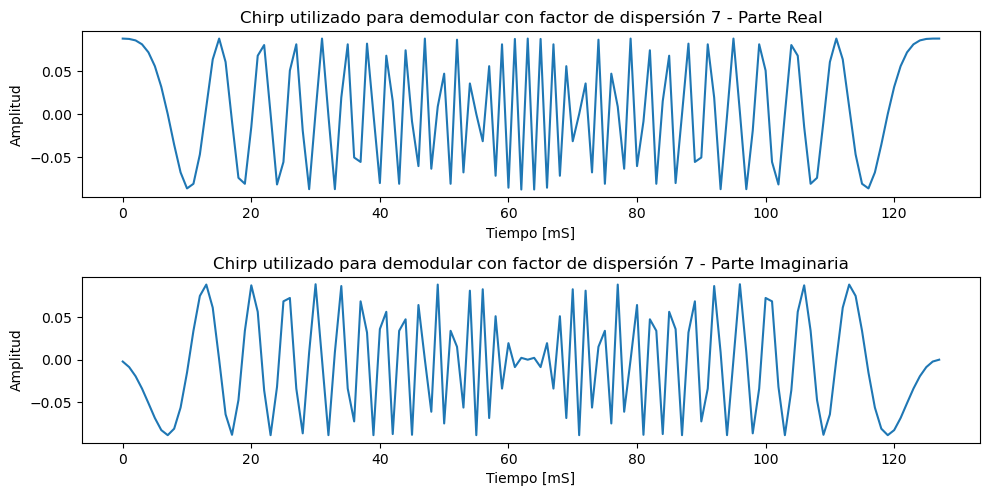

In [276]:
# Gráficas
plt.figure(figsize=(10, 12))

plt.subplot(5, 1, 1)
plt.plot(time_axis, base_down_chirp.real)
title_Text1 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Real"
plt.title(title_Text1)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.subplot(5, 1, 2)
plt.plot(time_axis, base_down_chirp.imag)
title_Text2 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Imaginaria"
plt.title(title_Text2)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

La señal recibida se multiplica por el _chirp_ descendente de referencia.

In [279]:
dechirped =  symb_ruidoso * base_down_chirp

Procedemos a graficar el símbolo demodulado.

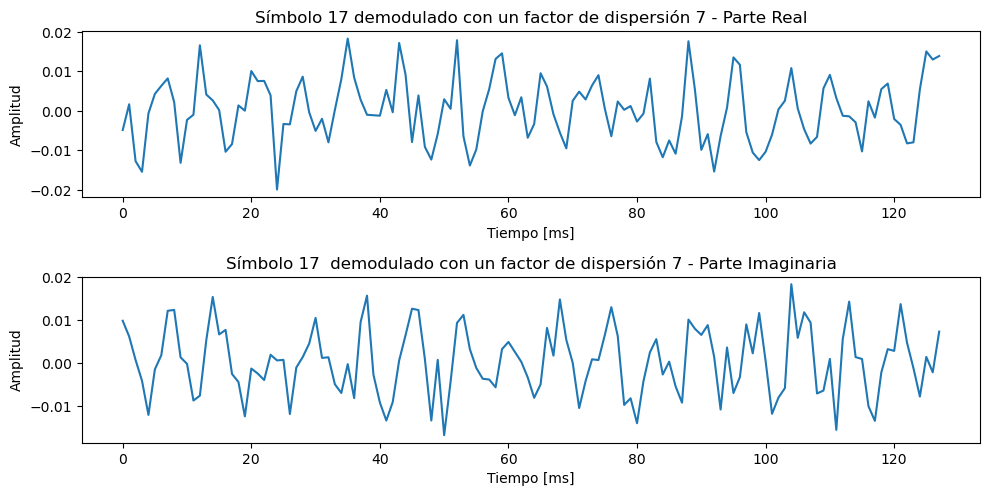

In [282]:
# Gráficas
plt.figure(figsize=(10, 12))

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 1)

plt.plot(time_axis, dechirped.real)
    
plt.title(f"Símbolo {str(s)} demodulado con un factor de dispersión {SF} - Parte Real")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 2)

plt.plot(time_axis, dechirped.imag)
    
plt.title(f"Símbolo {str(s)}  demodulado con un factor de dispersión {SF} - Parte Imaginaria")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

Como podemos ver al demodular nos quedamos con un tono, es decir, una señal que tiene una frecuencia dominante.

Aplicando la Transformada Rápida de Fourier podemos saber cuales son los tonos de mayor potencia y de esta manera distinguir los símbolos enviados.

In [285]:
dechirped_fft = np.fft.fft(dechirped)

Nuevamente gráficamos, esta vez, la potencia de cada frecuencia para poder verificar a simple vista los primeros símbolos recibidos.

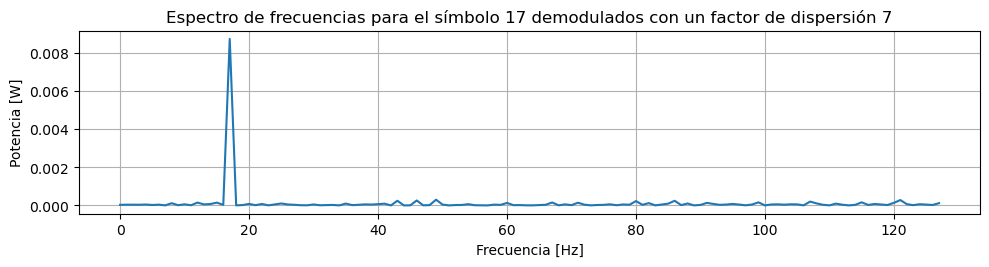

In [288]:
# Gráficas
plt.figure(figsize=(10, 12))

# Subplot 5: Espectro de frecuencias de los símbolos demodulados
plt.subplot(5, 1, 1)

f_sym = (np.arange(num_samples) * Fs / num_samples * 2**SF) / BW
power = np.abs(dechirped_fft)**2 / num_samples
plt.plot(f_sym, power)

plt.title(f"Espectro de frecuencias para el símbolo {str(s)} demodulados con un factor de dispersión {SF}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [W]")
plt.grid()

plt.tight_layout()
plt.show()

Y como vemos coincide con el símbolo transmitido.

### Simulación de una transmisión y recepción con modulación LoRa de varios símbolos

La idea es la siguiente: 
> La cantidad de bits a transmitir va a depender del _Spreading Factor_, entonces primero se van a definir todos los parámetros que influyen en la simulación y en base a estos se va a generar el mensaje aleatorio a transmitir.
> 
> Este mensaje será modulado mediante LoRa, al cual se le puede agregar ruido gausiano, efectos del canal satelital o que sea un canal ideal.
>
> Cabe aclarar que no se van a generar los símbolos del preámbulo y de la sincronización, solo se va a modular y demodular la información. Los datos van a ser una serie de símbolos aleatorios, comprendidos entre $0$ y $2^{SF}$ de manera aleatoria.  
> 
> Luego se simula la recepción y se procede a analizar el error.

Se comienza definiendo los parámetros de la simulación:

* `SF` Puede tomar valores entre $7$ y $12$
* `BW` es el ancho de banda en $Hz$. Me indica la frecuencia inicial y final de los "chirridos",
* `s` es el símbolo que se busca representar. La cantidad de símbolos a representar va a depender de `SF`.
  $$2^7 = 128$$
  $$2^8 = 256$$
  $$2^9 = 512$$
  $$2^{10} = 1024$$
  $$2^{11} = 2048$$
  $$2^{12} = 4096$$
  
* `SNR` es una medida que se utiliza para comparar el nivel de una señal deseada con el nivel de ruido de fondo. Se coloca en $dB$.
  
  Si es _positivo_ significa que la potencia de la señal es mayor que la potencia del ruido.

  Si es _negativo_ significa que la potencia del ruido es mayor que la potencia de la señal.
  
* Y el `numero_ciclos` es la variable para indicar cuantas veces se envío o recibió ese dato.
* `cant_bits`
* `Fs`

In [ ]:
SF  = 7                  # Spreading Factor [7,8,9,10,11,12]
BW  = 1000               # Ancho de banda
#s   = 17                 # Símbolo a representar
SNR = 0                  # Signal Noise Radio
#numero_ciclos = 10000   # Cantidad de veces que se envía o recibe ese símbolo
cant_bits = 10000        # Cantidad de bits a transmitir  
Fs  = 1000               # Frecuencia de muestreo 
ruido = 1                # Tipo de ruido: 0-> Sin ruido, 1 -> AWGN, 2 -> Canal Satelital                               

#### Transmisor

Teniendo en cuenta el factor de dispersión (`SF`), generamos el mensaje aleatorio a enviar:

In [ ]:
x = np.random.randint(0, 2**SF, size=cant_bits)

El vector $x$ representa directamente la salida del encoder.

##### Modulación

A continuación se define la función para modular una onda para cada símbolo *s* dado.

Donde: 

$T_s = \frac{2^{SF}}{BW}$ y esto me indica la duración de cada símbolo, su periodo.

$num samples = T_s F_s$ es el número de muestras en un periodo. 

$s$ es el símbolo que se quiere representar.

$SF$ es el _Spreading Factor_ ya definido al comienzo.

In [ ]:
def generar_symb(Ts, num_samples, s, SF):
    
    k = s
    
    symb_f = np.zeros(num_samples, dtype=np.float64)
    symb_t = np.zeros(num_samples, dtype=np.complex128)

    for n in range(num_samples):
        
        if k >= 2**SF:
            k = k - 2**SF
        
        k = k + 1
        symb_f[n] = k
        symb_t[n] = (1 / np.sqrt(2**SF)) * np.exp(1j * 2 * np.pi * k * (k / (2 * 2**SF)))

    return symb_t, symb_f

Se procede a definir el periodo de cada símbolo y su tasa de muestreo para hacer uso de la función anterior.

In [ ]:
Ts = (2**SF)/BW            # Periodo de cada símbolo
num_samples = int(Ts * Fs) # Número de muestras

print("Duración de casa símbolo: ", Ts, " [S]")

Se definen las listas para guardar los resultado devueltos por la función. 
Y se recorre el vector que contiene la información ($x$), para modular cada símbolo:

In [ ]:
all_symb_t = []
all_symb_f = []

# Recorrer el vector x y llamar a generar_symb para cada valor
for s in x:
    symb_t, symb_f = generar_symb(Ts, num_samples, s, SF)
    all_symb_t.append(symb_t)
    all_symb_f.append(symb_f)

Procedemos a gráficar como se vería las variaciones de frecuencia y tiempo por símbolo en el eje real.

Se puede mencionar que cambiando la variable `num_symbols_to_plot` se modifica la cantidad de símbolos a ver. Recordar que la cantidad total se definió al principio con la cantidad de bits a transmitir.

In [ ]:
# Número de símbolos a graficar y parte del mensaje a mostrar
num_symbols_to_plot = 3
message_part = 2**SF   # Cantidad de puntos de cada símbolo

# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 1: Variación de frecuencia por símbolo (solo los primeros símbolos)
plt.subplot(5, 1, 1)

for i in range(num_symbols_to_plot):
    time_offset = i * num_samples * 1000 / Fs
    plt.plot(time_offset + np.arange(message_part) * 1000 / Fs, all_symb_f[i][:message_part].real, label=f'Símbolo {x[i]}')

title_Text1 = f"Variación de frecuencia por símbolo con un factor de dispersión {SF} - Parte Real"
plt.title(title_Text1)
plt.xlabel("Tiempo [ms]")
plt.ylabel("Frecuencia [Hz]")
plt.legend()


# Subplot 2: Variación de tiempo por símbolo (solo los primeros símbolos)
plt.subplot(5, 1, 2)

for i in range(num_symbols_to_plot):
    time_offset = i * num_samples * 1000 / Fs
    plt.plot(time_offset + np.arange(message_part) * 1000 / Fs, all_symb_t[i][:message_part].real, label=f'Símbolo {x[i]}')

title_Text2 = f"Variación de tiempo por símbolo con un factor de dispersión {SF} - Parte Real"
plt.title(title_Text2)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

Con las imagenes anteriores podemos ver como es la modulación LoRa.

#### Ruido

En este momento se le puede agregar ruido a la señal, depende de como se configuro el parámetro antes.

Primero definimos una función para agregar ruido.

In [ ]:
def agregar_ruido(simbolo_lora, SNR, modo):

    if modo == 0: # Sin ruido - canal ideal
        
        return simbolo_lora
    
    else: # Ruido AWGN   
        # Cálculo de potencia de señal y conversión a decibelios
        prom_watts = np.mean(np.abs(simbolo_lora)**2)
        prom_db = 10 * np.log10(prom_watts)

        # Cálculo de ruido en watts
        prom_ruido_db = prom_db - SNR
        noise_avg_watts = 10 ** (prom_ruido_db / 10)

        # Generar ruido blanco complejo
        noise = np.sqrt(noise_avg_watts / 2) * (np.random.normal(0, 1, len(simbolo_lora)) + 1j * np.random.normal(0, 1, len(simbolo_lora)))

        # Añadir ruido a la señal original
        simb_ruidoso = simbolo_lora + noise
    
        return simb_ruidoso

Y ahora se agrega ruido a la señal. Se generan los símbolos ruidosos.

In [ ]:
symb_ruidosos = []

for symb in all_symb_t:
    symb_ruidoso = agregar_ruido(symb, SNR, ruido)
    symb_ruidosos.append(symb_ruidoso)

Y podemos nuevamente gráficar los primeros símbolos para apreciar el efecto.

In [ ]:
# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 2: Variación de tiempo por símbolo (solo los primeros símbolos)
plt.subplot(5, 1, 3)

for i in range(num_symbols_to_plot):
    time_offset = i * num_samples * 1000 / Fs
    plt.plot(time_offset + np.arange(message_part) * 1000 / Fs, symb_ruidosos[i][:message_part].real, label=f'Símbolo {x[i]}')

title_Text2 = f"Variación de tiempo por símbolo con un factor de dispersión {SF} - Parte Real"
plt.title(title_Text2)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

#### Receptor

Para recibir la señal lo primero que se hace es detectar la parte del préambulo y de sincronización. Estas se eliminan, y nos quedamos con la información.

##### Demodulación

Para generar la demodulación, se debe generar un "chirp" o "chirrido" como antes vimos. De cierta manera es análogo a una señal portadora o _carrier_ en otras modulaciones como AM, FM, etc. 

In [ ]:
base_down_chirp = np.zeros(num_samples, dtype=np.complex128)
k = 0

for n in range(num_samples):
    if k >= 2**SF:
        k = k - 2**SF
    k = k + 1
    base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2)))

Y se puede gráficar para observar como sería la señal utilizada para la demodulación.

In [ ]:
time_axis = np.arange(num_samples) * 1000 / Fs     #Vector tiempo que será usado en esta imagne y la siguiente

# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 3: Chirp utilizado para demodular
plt.subplot(5, 1, 4)
plt.plot(time_axis[:message_part], base_down_chirp[:message_part].real)
title_Text3 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Real"
plt.title(title_Text3)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.subplot(5, 1, 5)
plt.plot(time_axis[:message_part], base_down_chirp[:message_part].imag)
title_Text3 = f"Chirp utilizado para demodular con factor de dispersión {SF} - Parte Imaginaria"
plt.title(title_Text3)

plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

plt.tight_layout()
plt.show()

Notar que `time_axis` es un arreglo que contiene los tiempo correspondientes a cada "chirrido".
Se seleccionó la primer muestra del arreglo de tiempo con `message_part`, que me indica la cantidad de puntos de cada símbolo. De esta manera se definió el vector tiempo.

Y el vector `base_down_chirp` es el que contiene los valores del chirrido a lo largo del tiempo, como se indico un poco más arriba.

Ahora se realiza propiamente la demodulación, para ello se itera sobre cada símbolo y aplicó la demodulación a cada uno. Tener en cuenta que `all_symb_t` contiene los símbolos modulados. 


In [ ]:
all_dechirped = []

for i in symb_ruidosos:
    dechirped = i * base_down_chirp
    all_dechirped.append(dechirped)

Procedemos a graficar los símbolos demodulados.

In [ ]:
# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 1)

for i in range(num_symbols_to_plot):
    plt.plot(time_axis, all_dechirped[i][:message_part].real, label=f'Símbolo {x[i]}')
    
plt.title(f"Símbolos demodulados con un factor de dispersión {SF} - Parte Real")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.legend()

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 2)

for i in range(num_symbols_to_plot):
    plt.plot(time_axis, all_dechirped[i][:message_part].imag, label=f'Símbolo {x[i]}')
    
plt.title(f"Símbolos demodulados con un factor de dispersión {SF} - Parte Imaginaria")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.legend()

plt.tight_layout()
plt.show()

Como podemos ver al demodular nos quedamos con varios tonos, es decir, distintas señales de que tienen una frecuencia dominante.

Aplicando la Transformada Rápida de Fourier podemos saber cuales son los tonos de mayor potencia y de esta manera distinguir los símbolos enviados.

In [ ]:
all_dechirped_fft = []

for i in all_dechirped:
    dechirped_fft = np.fft.fft(i)
    all_dechirped_fft.append(dechirped_fft)

Nuevamente gráficamos, esta vez, la amplitud de cada frecuencia para poder verificar a simple vista los primeros símbolos recibidos.

In [ ]:
# Gráficas
plt.figure(figsize=(10, 15))

# Subplot 5: Espectro de frecuencias de los símbolos demodulados
plt.subplot(5, 1, 1)

for i in range(num_symbols_to_plot):
    f_sym = (np.arange(num_samples) * Fs / num_samples * 2**SF) / BW
    power = np.abs(all_dechirped_fft[i])**2 / num_samples
    plt.plot(f_sym, power, label=f'Símbolo {x[i]}')

plt.title(f"Espectro de frecuencias para los símbolos demodulados con un factor de dispersión {SF}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [W]")
plt.legend()

plt.tight_layout()
plt.show()

Donde se puede ver que los símbolos obtenidos y compararlos con los símbolos enviados.

Cambiando los parámetros del inicio de la simulación obtenenmos diferentes casos.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt

# Definir parámetros
SF = 8
BW = 1000
Fs = 1000
T = 1 / BW
Ts = 2**SF * T
num_samples = int(Ts * Fs)
num_symbols = 3

# Generar varios símbolos aleatorios
symbols = np.random.randint(0, 2**SF, num_symbols)

def generar_symb(Ts, num_samples, s, SF):
    k = s
    symb_f = np.zeros(num_samples, dtype=np.float64)
    symb_t = np.zeros(num_samples, dtype=np.complex128)

    for n in range(num_samples):
        if k >= 2**SF:
            k = k - 2**SF
        k = k + 1
        symb_f[n] = k
        symb_t[n] = (1 / np.sqrt(2**SF)) * np.exp(1j * 2 * np.pi * k * (k / (2 * 2**SF)))

    return symb_t, symb_f

# Generar el chirp para demodulación
base_down_chirp = np.zeros(num_samples, dtype=np.complex128)
k = 0
for n in range(num_samples):
    if k >= 2**SF:
        k = k - 2**SF
    k = k + 1
    base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2)))

# Variables para almacenar los resultados
all_symb_t = []
all_symb_f = []
all_dechirped = []
all_dechirped_fft = []

# Procesar cada símbolo
for s in symbols:
    symb_t, symb_f = generar_symb(Ts, num_samples, s, SF)
    dechirped = symb_t * base_down_chirp
    dechirped_fft = np.fft.fft(dechirped)
    
    all_symb_t.append(symb_t)
    all_symb_f.append(symb_f)
    all_dechirped.append(dechirped)
    all_dechirped_fft.append(dechirped_fft)

# Convertir listas a arrays para facilitar el manejo
all_symb_t = np.array(all_symb_t)
all_symb_f = np.array(all_symb_f)
all_dechirped = np.array(all_dechirped)
all_dechirped_fft = np.array(all_dechirped_fft)

# Graficar los resultados
plt.figure(figsize=(15, 10))

# Subplot 1: Variación de frecuencia por símbolo
plt.subplot(5, 1, 1)
for i, symb_f in enumerate(all_symb_f):
    plt.plot(np.linspace(0, Ts, num_samples) * 1000, symb_f, label=f'Símbolo {symbols[i]}')
plt.title(f"Variación de frecuencia por símbolo con un factor de dispersión {SF}")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Frecuencia [Hz]")
plt.legend()

# Subplot 2: Símbolos modulados
plt.subplot(5, 1, 2)
for i, symb_t in enumerate(all_symb_t):
    plt.plot(np.linspace(0, Ts, num_samples) * 1000, symb_t.real, label=f'Símbolo {symbols[i]}')
plt.title(f"Símbolos modulados con un factor de dispersión {SF}")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.legend()

# Subplot 3: Chirp utilizado para demodular
plt.subplot(5, 1, 3)
plt.plot(np.linspace(0, Ts, num_samples) * 1000, base_down_chirp.real)
plt.title(f"Chirp utilizado para demodular con factor de dispersión {SF}")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")

# Subplot 4: Símbolos demodulados
plt.subplot(5, 1, 4)
for i, dechirped in enumerate(all_dechirped):
    plt.plot(np.linspace(0, Ts, num_samples) * 1000, dechirped.real, label=f'Símbolo {symbols[i]}')
plt.title(f"Símbolos demodulados con un factor de dispersión {SF}")
plt.xlabel("Tiempo [ms]")
plt.ylabel("Amplitud")
plt.legend()

# Subplot 5: Espectro de frecuencias de los símbolos demodulados
plt.subplot(5, 1, 5)
for i, dechirped_fft in enumerate(all_dechirped_fft):
    f_sym = (np.arange(num_samples) * Fs / num_samples * 2**SF) / BW
    power = np.abs(dechirped_fft)**2 / num_samples
    plt.plot(f_sym, power, label=f'Símbolo {symbols[i]}')
plt.title(f"Espectro de frecuencias para los símbolos demodulados con un factor de dispersión {SF}")
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [W]")
plt.legend()

plt.tight_layout()
plt.show()


* `SF` Puede tomar valores entre $7$ a $12$
* `BW` es el ancho de banda en $Hz$
* `s` es el símbolo que se busca representar
* `SNR` es una medida que se utiliza para comparar el nivel de una señal deseada con el nivel de ruido de fondo. Se coloca en $dB$.
  
  Si es _positivo_ significa que la potencia de la señal es mayor que la potencia del ruido.

  Si es _negativo_ significa que la potencia del ruido es mayor que la potencia de la señal.
  
* `numero_ciclos`

In [ ]:
SF  = 7     # Spreading Factor [7,8,9,10,11,12]
BW  = 1000  # Ancho de banda
s   = 17    # Símbolo a representar
SNR = 5     # Signal Noise Radio
numero_ciclos = 10000

generamos el símbolo con la siguiente operación:

$$\Large \frac{1}{\sqrt{2^{SF}}}e^{j2\pi\frac{k^2}{2^{SF}}}$$


In [ ]:
var1 = 2**SF
num_samples = var1

k = s
simbolo_real = np.linspace(1, num_samples, num_samples)
simbolo_real = np.asarray(simbolo_real, dtype=int)
simbolo_lora = np.zeros(num_samples, dtype=complex)

i = 0

for i in range (0, num_samples):
    if(k >= var1):
        k = k - var1
    k = k + 1
    simb = (complex(1/(math.sqrt(var1)))*cmath.exp(1j*2*math.pi*k*(k/(2*var1))))
    simbolo_lora[i] = simb

In [ ]:
aciertos = np.zeros(numero_ciclos)
for i in range(0, numero_ciclos):
    
    #añadir ruido

    # Cálculo de potencia de señal y conversión a decibelios
    prom_watts = np.mean(np.abs(simbolo_lora)**2)
    prom_db = 10 * np.log10(prom_watts)

    # Cálculo de ruido en watts
    prom_ruido_db = prom_db - SNR
    noise_avg_watts = 10 ** (prom_ruido_db / 10)

    # Generar ruido blanco complejo
    noise = np.sqrt(noise_avg_watts / 2) * (np.random.normal(0, 1, len(simbolo_lora)) + 1j * np.random.normal(0, 1, len(simbolo_lora)))

    # Añadir ruido a la señal original
    simb_ruidoso = simbolo_lora + noise

    # generando base down chirp
    base_down_chirp = np.zeros(num_samples, dtype=complex)
    k = 0
    for j in range (0, num_samples):
        if (k>=var1):
            k = k - var1
        k = k+1
        simb = (complex(1/math.sqrt(var1)))*cmath.exp(-1j*2*math.pi*k*(k/(2*var1)))
        base_down_chirp[j] = simb

    dechirped = simb_ruidoso*base_down_chirp #dechirping the signal

    #Fast Fourier Transform
    correlation = abs(fft(dechirped))**2

    #Encotrando el valor máximo
    aciertos[i] = correlation.argmax()

# plot the complex number
# La primera gráfica podemos ver la correlación, compara el símbolo enviado con cada símbolo desde 0 hasta 2^{SF}-1
plt.plot(simbolo_real, correlation, '-b')
plt.ylabel('Correlation')
plt.xlabel('Signo')
plt.show()

# La segunda gráfica me indica cuantas veces el programa dijo que era cierto símbolo.
plt.hist(aciertos)
plt.ylabel('Cantidad de ciclos')
plt.xlabel('Signo')
plt.show()

error = sum(aciertos != s)/numero_ciclos
print("Error: " + str(error))

Se puede concluir que para ambiente ruidosos, donde el ruido es mayor a la señal se debe utilizar un _Spreading Factor_ alto. 
Ej: SNR = -20 dB --> SF = 12 

En cambio para ambientes con poco ruido, con SF = 7 vemos que se obtiene un error también nulo. 

Simulación de la modulación LoRa y su comportamiento ante el ruido!

Se define la función para modular una onda para un símbolo dado *s*

In [ ]:
def generar_symb(Ts, Fs, s, SF):
    
    num_samples = int(Ts * Fs)
    k = s
    
    symb_f = np.zeros(num_samples, dtype=np.float64)
    symb_t = np.zeros(num_samples, dtype=np.complex128)

    for n in range(num_samples):
        if k >= 2**SF:
            k = k - 2**SF
        k = k + 1
        symb_f[n] = k
        symb_t[n] = (1 / np.sqrt(2**SF)) * np.exp(1j * 2 * np.pi * k * (k / (2 * 2**SF)))

    return symb_t, symb_f

En la función anterior se esta modulando la señal para un símbolo *s* dado.

Se define la característica de la modulación, los parámetros son:

In [ ]:
SF = 8
BW = 1000
Fs = 1000
s = 128 # Se define el símbolo que se va a transmitir
SNR = -10 # Se define la relación señal - ruido 

Se define el periodo de muestreo y la duración de cada símbolo

In [ ]:
T = 1/BW           # Período de muestreo
Ts = 2**SF * T     # Período en general
num_sample = int(Ts*Fs) # Número de muestras

n_sy = 1 # Número de símbolos

Se calculan los símbolos para enviar un payload

In [ ]:
[symb_t, symb_f] = generar_symb(Ts, Fs, s, SF)

Se define el vector tiempo para n_sy símbolos

In [ ]:
x = np.linspace(0,n_sy*Ts, n_sy*(2**SF))

Se realiza la transmisión, para ello debemos generar un *chirp*. Es de ciertamente analogo a un carrier si lo comparamos con otras modulaciones.

In [ ]:
base_down_chirp = np.zeros(num_sample, dtype=np.complex128)
k = 0

for n in range(num_sample):
    if k >= 2**SF:
        k = k - 2**SF
    k = k + 1
    base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2)))

Ahora se realiza la demodulación:

In [ ]:
dechirped = symb_t * base_down_chirp 
dechirped_fft = np.fft.fft(dechirped)

Generamos la transformada de Fourier:

In [ ]:
n = len(dechirped_fft)  # número de muestras
f = np.arange(n) * (Fs / n)  # rango de frecuencia

f_sym = (f * 2**SF) / BW  # frecuencia simbólica

power = np.abs(dechirped_fft)**2 / n  # potencia de la señal

Los gráficos:

In [ ]:
plt.figure(figsize=(10, 12))

# Subplot 1: Variación de frecuencia por símbolo
plt.subplot(5, 1, 1)
plt.plot(x * 1000, symb_f)
title_Text1 = "Variación de frecuencia por símbolo " + str(s) + " con un factor de dispersión " + str(SF)
plt.title(title_Text1)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Frecuencia [Hz]")

# Subplot 2: Símbolo modulado
plt.subplot(5, 1, 2)
plt.plot(x, symb_t)
title_Text2 = "Símbolo " + str(s) + " modulado con un factor de dispersión " + str(SF)
plt.title(title_Text2)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

# Subplot 3: Chirp utilizado para demodular
plt.subplot(5, 1, 3)
plt.plot(x, base_down_chirp)
title_Text3 = "Chirp utilizado para demodular con factor de dispersión " + str(SF)
plt.title(title_Text3)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

# Subplot 4: Símbolo demodulado
plt.subplot(5, 1, 4)
plt.plot(x, dechirped)
title_Text4 = "Símbolo " + str(s) + " demodulado con un factor de dispersión " + str(SF)
plt.title(title_Text4)
plt.xlabel("Tiempo [mS]")
plt.ylabel("Amplitud")

# Subplot 5: Espectro de frecuencias
plt.subplot(5, 1, 5)
plt.plot(f_sym, power)
title_Text5 = "Espectro de frecuencias para símbolo " + str(s) + " demodulado con un factor de dispersión " + str(SF)
plt.title(title_Text5)
plt.xlabel("Frecuencia [Hz]")
plt.ylabel("Potencia [W]")

plt.tight_layout()  # Ajusta automáticamente el espaciado entre subplots
plt.show()

En la primer gráfica podemos ver que incia en la frecuencia del símbolo a transmitir y asciende hasta su máximo $2^{SF}$ provocando una discontinuidad, y vuelve a empezar.  

En la segunda gráfica se aprecia como cambia la frecuencia de la onda con la modulación _chirp_ para el símbolo a transmitir. Se nota que en la discontinuidad es donde se tiene menor frecuencia.

La tercer señal vemos el chirp utilizado para demodular. Es el conjugado de la modulación, es decir, el conjugado de la señal anterior.

En la cuarta gráfica se obtiene la señal demodulada, esta señal tiene una frecuencia constante y ese valor nos va a permitir saber el símbolo que se esta enviando.

Y en la última se muestran los valores de frecuencia de la señal anterior, y vemos claramente que la información se encuentra en la frecuencia. 


`Esta parte esta mal, no representa el error de la modulación LoRa.` _(PARTE DE ABAJO)_

Ahora se le agrega ruido a la simulación.

Se definen nuevamente las características de la modulación.

In [ ]:
SF = 10
BW = 1000
Fs = 1000
s = 189
SNR = -20

Se define el número de muestras:

In [ ]:
# Configuración inicial
SF = 8
BW = 1000
Fs = 1000
s = 189
SNR = -10

# Número de muestras
num_samples = int((2**SF) * Fs / BW)
k = s
lora_symbol = np.zeros(num_samples, dtype=np.complex128)

# Se obtiene la señal modulada para el símbolo dado s
for n in range(num_samples):
    if k >= (2**SF):
        k = k - 2**SF
    k = k + 1
    lora_symbol[n] = (1 / np.sqrt(2**SF)) * np.exp(1j * 2 * np.pi * k * (k / (2**SF * 2)))

ind2 = np.zeros(100, dtype=int)  # Arreglo para guardar los índices de máximos

for j in range(100):
    # Agrega ruido
    # Cálculo de potencia de señal y conversión a decibelios
    prom_watts = np.mean(np.abs(lora_symbol)**2)
    prom_db = 10 * np.log10(prom_watts)
    
    # Cálculo de ruido en watts
    prom_ruido_db = prom_db - SNR
    noise_avg_watts = 10 ** (prom_ruido_db / 10)
    
    # Generar ruido blanco complejo
    noise = np.sqrt(noise_avg_watts / 2) * (np.random.normal(0, 1, len(lora_symbol)) + 1j * np.random.normal(0, 1, len(lora_symbol)))
    
    # Añadir ruido a la señal original
    lora_symbol_noisy = lora_symbol + noise

    # Transmite y se genera el chirp para demodular
    base_down_chirp = np.zeros(num_samples, dtype=np.complex128)
    k = 0
    for n in range(num_samples):
        if k >= (2**SF):
            k = k - 2**SF
        k = k + 1
        base_down_chirp[n] = (1 / np.sqrt(2**SF)) * np.exp(-1j * 2 * np.pi * k * (k / (2**SF * 2)))

    # Demodulación
    dechirped = lora_symbol_noisy * base_down_chirp

    # Transformada rápida de Fourier - correlación
    corrs = np.abs(np.fft.fft(dechirped))**2

    # Encontrar el índice del máximo
    ind = np.argmax(corrs)
    ind2[j] = ind

# Figura 1
plt.figure(1)
plt.plot(corrs)
titleText = "Espectro de frecuencias para símbolo " + str(s) + ", factor de dispersión " + str(SF) + " y SNR de " + str(SNR) + " dB"
plt.title(titleText)
plt.xlabel("Frecuencia")
plt.ylabel("Magnitud")

# Figura 2
plt.figure(2)
plt.hist(ind2, bins=2**SF)
plt.title("Histograma de ind2")
plt.xlabel("Índices")
plt.ylabel("Frecuencia")
plt.show()

# Error de correlación
symbol_error_rate = np.sum(ind2 != s + 1) / len(ind2)
print("Tasa de error de símbolo:", symbol_error_rate)


## Bibliografía

### Vídeos

* https://www.youtube.com/watch?v=8AWY80NKc-A
* https://www.youtube.com/watch?v=kNXnCjJplZw&t
* https://www.youtube.com/watch?v=mKmOlMqrbKk
* https://www.youtube.com/watch?v=dxYY097QNs0
* https://www.youtube.com/watch?v=0zNFtDZ7bMs
* https://www.youtube.com/watch?v=dpA-uWL6FUA

### Papers

### Páginas web

* https://www.sghoslya.com/p/lora_9.html
* http://www.sghoslya.com/
* https://revspace.nl/DecodingLora
* 

In [ ]:
%history